In [27]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [28]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                        data["sub_experiment_path"] = seed_path
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    cfg_data["sub_experiment_path"] = seed_folder_path 
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            key = f"sub_exp_cfg_{key.strip()}"  # Add prefix
            variables[key] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [29]:
experiment_sub_dir = "2025Mar21-013722_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_estimator.args_.lin_hidden_out_size',
       'sub_experiment_path', 'seed', 'experiment_name'],
      dtype='ob

In [30]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_experiment_path,seed,experiment_name
0,training,200000,-146.195934,-81.986693,-104.159923,-103.561686,8.500378,-29.485750,-23.107818,-25.809291,...,-0.455308,0.702751,24374.0,48.0,0 days 00:02:15.329742,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
1,training,400000,-129.667809,-77.353660,-98.875521,-98.529376,8.156908,-28.494253,-23.062935,-25.293241,...,-1.018806,1.151297,25000.0,48.0,0 days 00:02:24.415925,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
2,training,600000,-121.056406,-71.765361,-90.001096,-89.615238,6.338127,-27.973676,-23.018708,-25.113045,...,-1.317625,1.386895,25000.0,48.0,0 days 00:02:32.442129,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
3,training,800000,-118.161978,-72.851136,-91.298945,-90.776600,6.208961,-28.633705,-23.385392,-25.784686,...,-1.427309,1.533950,25000.0,48.0,0 days 00:02:35.716994,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
4,training,1000000,-113.590191,-75.451454,-91.203545,-90.878816,5.803210,-28.676569,-23.551611,-25.843768,...,-1.409024,1.610076,25000.0,56.0,0 days 00:02:39.052639,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,validation,3200000,-94.122750,-94.059427,-94.099644,-94.100537,0.015993,-25.588859,-25.581861,-25.586243,...,-1.572913,1.671208,NaN,NaN,0 days 00:00:00.499858,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...
1596,validation,3400000,-93.889748,-93.460575,-93.551938,-93.511606,0.118686,-25.589312,-25.582349,-25.586407,...,-1.617073,1.685330,NaN,NaN,0 days 00:00:00.484908,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...
1597,validation,3600000,-95.665381,-95.627584,-95.643589,-95.643908,0.010410,-25.588543,-25.582453,-25.584947,...,-1.451329,1.667534,NaN,NaN,0 days 00:00:00.470534,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...
1598,validation,3800000,-95.089942,-93.480700,-93.649358,-93.509930,0.422264,-25.678779,-25.579268,-25.592248,...,-1.630150,1.686755,NaN,NaN,0 days 00:00:00.488648,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...


In [31]:
# normalize rewards?

In [32]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_experiment_path,seed,experiment_name
20,validation,200000,-75.920775,-75.655758,-75.900389,-75.920775,7.061903e-02,-23.764147,-23.763683,-23.763719,...,-0.591342,0.975965,NaN,NaN,0 days 00:00:00.635180,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
21,validation,400000,-73.216426,-73.216426,-73.216426,-73.216426,1.421085e-14,-22.689784,-22.689784,-22.689784,...,-0.439080,1.208492,NaN,NaN,0 days 00:00:00.595345,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
22,validation,600000,-68.841799,-68.210669,-68.245959,-68.210669,1.445156e-01,-23.925732,-23.825629,-23.831221,...,-1.408106,1.475032,NaN,NaN,0 days 00:00:00.629179,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
23,validation,800000,-73.079244,-72.126236,-72.182295,-72.126236,2.242372e-01,-24.620858,-24.505794,-24.512562,...,-1.376539,1.593984,NaN,NaN,0 days 00:00:00.626467,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
24,validation,1000000,-74.267532,-73.860360,-73.884311,-73.860360,9.580529e-02,-24.717597,-24.716520,-24.716583,...,-1.573386,1.640070,NaN,NaN,0 days 00:00:00.593383,0,16,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,validation,3200000,-94.122750,-94.059427,-94.099644,-94.100537,1.599288e-02,-25.588859,-25.581861,-25.586243,...,-1.572913,1.671208,NaN,NaN,0 days 00:00:00.499858,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...
1596,validation,3400000,-93.889748,-93.460575,-93.551938,-93.511606,1.186859e-01,-25.589312,-25.582349,-25.586407,...,-1.617073,1.685330,NaN,NaN,0 days 00:00:00.484908,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...
1597,validation,3600000,-95.665381,-95.627584,-95.643589,-95.643908,1.040951e-02,-25.588543,-25.582453,-25.584947,...,-1.451329,1.667534,NaN,NaN,0 days 00:00:00.470534,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...
1598,validation,3800000,-95.089942,-93.480700,-93.649358,-93.509930,4.222637e-01,-25.678779,-25.579268,-25.592248,...,-1.630150,1.686755,NaN,NaN,0 days 00:00:00.488648,1,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0019_agent_params.args_.action_w_noise_amplitu...


In [33]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude     0
sub_exp_cfg_estimator.args_.lin_hidden_out_size            64
Name: 3, dtype: object
Best mean reward: -62.50014409007654


In [34]:
averaged_results

,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_estimator.args_.lin_hidden_out_size,episode_rewards_mean,sub_experiment_path
0,0,128,-101.294198,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,0,16,-77.406674,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,0,32,-93.232674,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,0,64,-62.500144,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
4,0.1,128,-97.472414,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
5,0.1,16,-92.223170,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
6,0.1,32,-113.730182,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
7,0.1,64,-133.064298,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
8,0.3,128,-85.668521,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
9,0.3,16,-82.129774,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


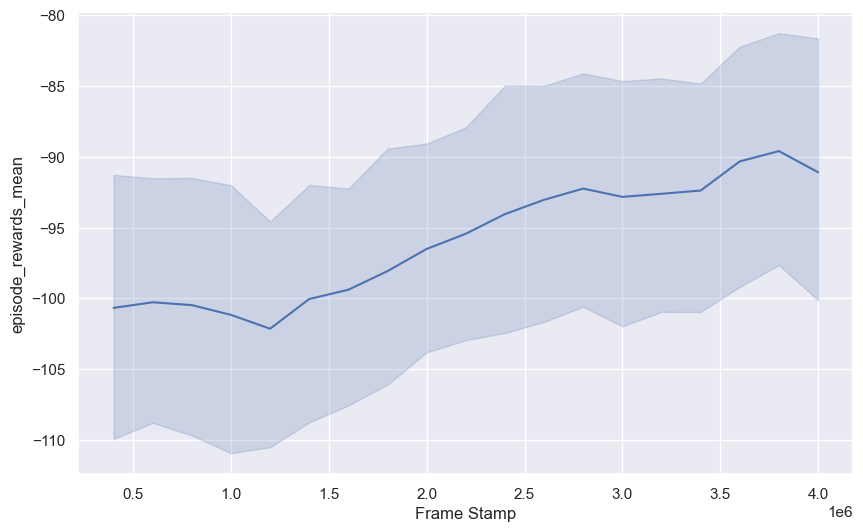

In [35]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

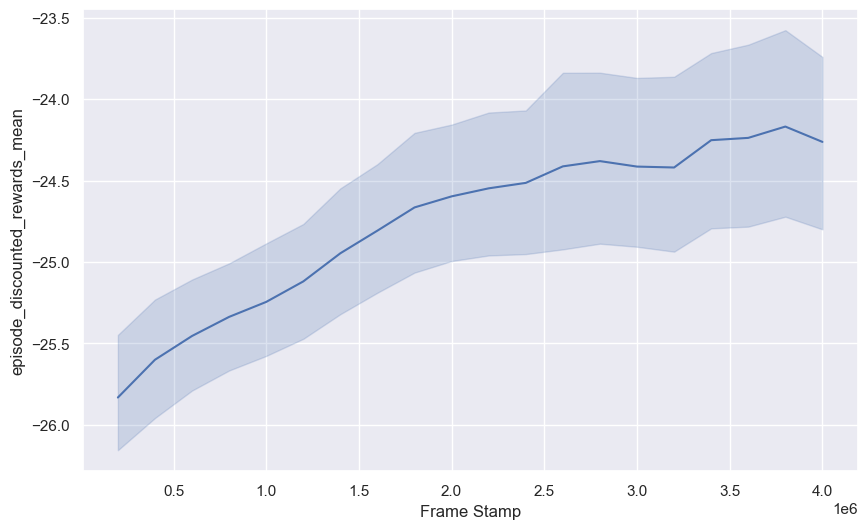

In [36]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [37]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_estimator.args_.lin_hidden_out_size
39,validation,4000000,-69.696657,63.000000,-23.602519,NaN,NaN,0 days 00:00:00.591853,0,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,16
79,validation,4000000,-52.509505,63.000000,-18.048636,NaN,NaN,0 days 00:00:00.579609,1,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,16
119,validation,4000000,-69.719425,71.000000,-22.141988,NaN,NaN,0 days 00:00:00.634253,0,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,32
159,validation,4000000,-79.132658,74.000000,-24.087420,NaN,NaN,0 days 00:00:00.653010,1,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,32
199,validation,4000000,-60.168262,65.000000,-20.576862,NaN,NaN,0 days 00:00:00.615137,0,0002_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,64
239,validation,4000000,-31.844159,27.000000,-16.993054,NaN,NaN,0 days 00:00:00.746398,1,0002_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,64
279,validation,4000000,-94.424289,82.076923,-25.645749,NaN,NaN,0 days 00:00:00.733765,0,0003_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,128
319,validation,4000000,-94.415634,83.000000,-25.592027,NaN,NaN,0 days 00:00:00.711304,1,0003_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,128
359,validation,4000000,-95.506483,86.000000,-25.594393,NaN,NaN,0 days 00:00:00.631811,0,0004_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.1,16
399,validation,4000000,-96.797639,97.000000,-25.590707,NaN,NaN,0 days 00:00:00.646198,1,0004_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.1,16


In [38]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Mar21-013722_configs\0002_agent_params.args_.action_w_noise_amplitude_0__estimator.args_.lin_hidden_out_size_64\1


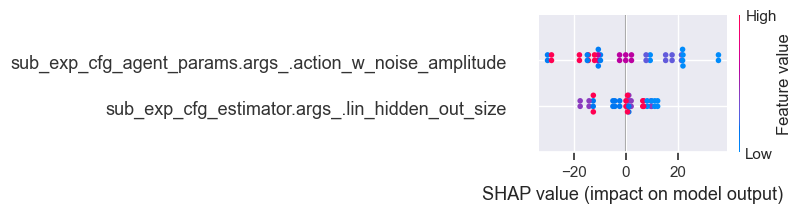

In [39]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [41]:
hyperparam_columns

['sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
 'sub_exp_cfg_estimator.args_.lin_hidden_out_size']

In [49]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
